# Machine Learning

## Imports

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

## Importar dados normalizados

In [8]:
dados = pd.read_csv('C:/Users/lucas/Documents/GitHub/INT/Manufatura Aditiva/Classificação Direção/Dados/Dados tratados.csv')
dados.head()

,Área S0,Modulus (Automatic Young's),Load at Fy ( 0.2 %) - LE,Tensao em Fy ( 0.2 %) - LE,Deformacao em Fy ( 0.2 %) - LE,Forca Max,Tensao na Forca Max - LR,Deformacao na Forca Max - LR,Forca na Forca na Quebra - LQ,Deformacao na Forca na Quebra - LQ,Plano,Plano ID
0,0.816843,0.187500,0.390476,0.147531,0.356275,0.778571,0.173452,0.505632,0.391892,0.578268,deitado,0
1,0.912370,0.207031,0.314286,0.000000,0.295547,0.778571,0.010531,0.530113,0.000000,0.627464,deitado,0
2,0.687619,0.125000,0.266667,0.122842,0.554656,0.578571,0.115287,0.714046,0.614865,0.453942,deitado,0
3,0.755887,0.320312,0.314286,0.117993,0.271255,0.714286,0.189186,0.583170,0.425676,0.539367,deitado,0
4,0.713242,0.082031,0.257143,0.092959,0.489879,0.592857,0.090627,0.570232,0.594595,0.527982,deitado,0


## Separando Treino e Teste para diferentes splits, usando cross fold validation. 

In [53]:
X = dados[['Tensao na Forca Max - LR','Deformacao na Forca na Quebra - LQ']]
y = dados['Plano ID']

n_splits = 10
test_size = 0.35

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

knn_score = []
sgd_score = []
svc_score = []
tree_score = []

for train_index, test_index in sss.split(X, y):    
    X_train,X_test,y_train,y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]

    #KNN
    knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier(n_neighbors=4))
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)
    knn_score.append(f1_score(y_test,pred_knn,average='weighted',pos_label="Plano ID"))
    
    #SGD
    sgd = make_pipeline(StandardScaler(),
                        SGDClassifier(max_iter=1000, tol=1e-3))
    sgd.fit(X_train, y_train)
    pred_sgd = sgd.predict(X_test)
    sgd_score.append(f1_score(y_test,pred_sgd,average='weighted',pos_label="Plano ID"))
    
    #SVC
    svc = make_pipeline(StandardScaler(),
                        SVC(kernel='sigmoid'))
    svc.fit(X_train,y_train)
    pred_svc = svc.predict(X_test)
    svc_score.append(f1_score(y_test,pred_svc,average='weighted',pos_label="Plano ID"))
    
    #Decision Trees
    tree = make_pipeline(StandardScaler(),
                        DecisionTreeClassifier())

    tree.fit(X_train,y_train)
    pred_tree = tree.predict(X_test)
    tree_score.append(f1_score(y_test,pred_tree,average='weighted',pos_label="Plano ID"))
    

def avg(array):
    return float(sum(array)/len(array))

knn_score = avg(knn_score)
sgd_score = avg(sgd_score)
svc_score = avg(svc_score)
tree_score = avg(tree_score)

print(f'F1 score for KNN={knn_score}, SGD={sgd_score}, SVC={svc_score}, Decision Trees={tree_score}')

F1 score for KNN=0.9853968253968255, SGD=0.970702947845805, SVC=0.9853968253968255, Decision Trees=0.9042743764172336


## Plotar resultados

In [ ]:
dados_plot = pd.read_csv('C:/Users/lucas/Documents/GitHub/INT/Manufatura Aditiva/Classificação Direção/Dados/Dados.csv')


### KNN

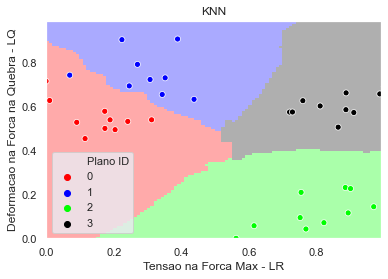

In [103]:
n_neighbors = 4
h = .01

x_min, x_max = X.iloc[:,0].min(), X.iloc[:,0].max() 
y_min, y_max = X.iloc[:,1].min(), X.iloc[:,1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#AAFFAA','#AFAFAF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF','#00FF00','#000000'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.scatterplot(x = 'Tensao na Forca Max - LR', y = 'Deformacao na Forca na Quebra - LQ', data= dados, hue = 'Plano ID', palette=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Tensao na Forca Max - LR')
plt.ylabel('Deformacao na Forca na Quebra - LQ')
plt.title('KNN')
plt.show()

### SVM

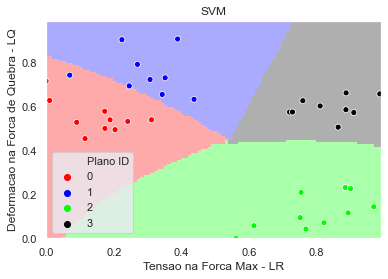

In [104]:
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#AAFFAA','#AFAFAF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF','#00FF00','#000000'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.scatterplot(x = 'Tensao na Forca Max - LR', y = 'Deformacao na Forca na Quebra - LQ', data= dados, hue = 'Plano ID', palette=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Tensao na Forca Max - LR')
plt.ylabel('Deformacao na Forca de Quebra - LQ')
plt.title('SVM')
plt.show()

### SGD

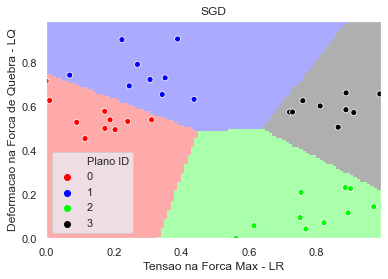

In [105]:
Z = sgd.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#AAFFAA','#AFAFAF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF','#00FF00','#000000'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.scatterplot(x = 'Tensao na Forca Max - LR', y = 'Deformacao na Forca na Quebra - LQ', data= dados, hue = 'Plano ID', palette=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Tensao na Forca Max - LR')
plt.ylabel('Deformacao na Forca de Quebra - LQ')
plt.title('SGD')
plt.show()

### Árvore de Decisão

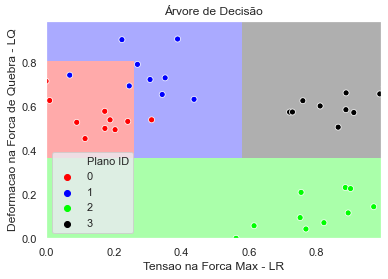

In [106]:
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#AAFFAA','#AFAFAF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF','#00FF00','#000000'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.scatterplot(x = 'Tensao na Forca Max - LR', y = 'Deformacao na Forca na Quebra - LQ', data= dados, hue = 'Plano ID', palette=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Tensao na Forca Max - LR')
plt.ylabel('Deformacao na Forca de Quebra - LQ')
plt.title('Árvore de Decisão')
plt.show()